In [1]:
import pandas as pd
import re
import glob
import os
import shutil
import json
from collections import defaultdict
nums = ['一', '二', '三', '四', '五', '六', '七', '八', '九', '十', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

In [2]:
# utils
def clean_str(raw_str):
    cleaned = raw_str.replace(' ', '')
    cleaned = cleaned.replace('\n', '')
    cleaned = cleaned.replace('\r', '')
    cleaned = cleaned.replace('\t', '')
    cleaned = re.sub(r"[A-Z]{4}\d{2}-\d{4}-\d{4}", "", cleaned)
    cleaned = re.sub(r"—\d{1,2}—", "", cleaned)
    cleaned = re.sub(r"-\d{1,2}-", "", cleaned)
    return cleaned

def is_Chinese(str):
    for ch in str:
        if '\u4e00' <= ch <= '\u9fff':
                return True
    return False

def split_title(sent):
    #     sent = '一、工业经济类（一）技术改造补助1.一般项目（1）对符合我区产业'
    split_idx = []
    match = re.search("[一|二|三|四|五|六|七|八|九|十]+\\.\D", sent)
    if match != None:
        split_idx.append(match.span()[0])
    match = re.search("[1|2|3|4|5|6|7|8|9|0]+\\.\D", sent)
    if match != None:
        split_idx.append(match.span()[0])
    match = re.search(r"[一|二| 三|四|五|六|七|八|九|十]+、", sent)
    if match != None:
        split_idx.append(match.span()[0])
    match = re.search(r"[1|2|3|4|5|6|7|8|9|0]+、", sent)
    if match != None:
        split_idx.append(match.span()[0])
    match = re.search(r"（[一|二|三|四|五|六|七|八|九|十]+）", sent)
    if match != None:
        split_idx.append(match.span()[0])
    match = re.search(r"（[1|2|3|4|5|6|7|8|9|0]+）", sent)
    if match != None:
        split_idx.append(match.span()[0])
    match = re.search("\\([一|二|三|四|五|六|七|八|九|十]+\\)", sent)
    if match != None:
        split_idx.append(match.span()[0])
    match = re.search("\\([1|2|3|4|5|6|7|8|9|0]+\\)", sent)
    if match != None:
        split_idx.append(match.span()[0])
    match = re.search("[1|2|3|4|5|6|7|8|9|0]+．", sent)
    if match != None:
        split_idx.append(match.span()[0])
    match = re.search(r"[一|二| 三|四|五|六|七|八|九|十]+．", sent)
    if match != None:
        split_idx.append(match.span()[0])
    
        
    if not split_idx:
        return [sent]
    split_idx = sorted(split_idx)
    sents = []
    for i, idx in enumerate(split_idx):
        if i == len(split_idx) - 1:
            sents.append(sent[idx:])
        else:
            sents.append(sent[idx:split_idx[i + 1]])
    return sents

def split_file(raw_sentences):
    sen = []
    new_sentence = []
    bracket = False
    for i in range(len(raw_sentences)):
        if raw_sentences[i] == '号' and re.match(r'[\u4e00-\u9fa5]+〔\d{4}〕\d+', ''.join(sen))!=None:
            sen.append(raw_sentences[i])
            sen = ''.join(sen)
            if re.match(r'[\u4e00-\u9fa5]+文件', sen)!=None:
                span = re.match(r'[\u4e00-\u9fa5]+文件', sen).span()
                sen = sen[span[1]:]
            new_sentence.append(sen)
            sen = []
            continue
        elif (raw_sentences[i] == ':' or  raw_sentences[i] == '：') and (i>=4 and raw_sentences[i-4:i]=='责任单位'):
            sen.append(raw_sentences[i])
        elif raw_sentences[i] == '：' and re.match(r'[\u4e00-\u9fa5]+各', ''.join(sen))!=None:
            sen.append(raw_sentences[i])
            sen = ''.join(sen)
            span = re.match(r'[\u4e00-\u9fa5]+各', sen).span()
            new_sentence.append(sen[:span[1]-1])
            new_sentence.append(sen[span[1]-1:])
            sen = []
            continue
        elif raw_sentences[i] == '。' and (i+2<len(raw_sentences) and raw_sentences[i+1] == '（' and raw_sentences[i+2] not in nums):
            sen.append(raw_sentences[i])
            bracket = True
        elif raw_sentences[i] == '）' and bracket and len(sen) > 0:
            bracket = False
            sen.append(raw_sentences[i])
            new_sentence.append(''.join(sen))
            sen = []
            continue
        elif raw_sentences[i] in ['。', ';', '；', ':', '：', '！', '？'] and len(sen) > 0:
            sen.append(raw_sentences[i])
            new_sentence.append(''.join(sen))
            sen = []
            continue
        elif raw_sentences[i] not in ['\r', '\n', '\x0c', '\u201e', '\u201f', ' ']:
            sen.append(raw_sentences[i])
    if len(sen) > 0:
        new_sentence.append(''.join(sen))
        
    new_sentences = []
    for sent in new_sentence:
        new_sentences.extend(split_title(sent))
        
#     new_sentence = [sent for sent in new_sentence if len(sent) > 1]
    new_sentences = [sent for sent in new_sentences if len(sent) > 1]
    return new_sentences

## 1 数据读取与处理

In [3]:
# policy = pd.read_excel('./data/政策文件内容.xlsx')
# policy.head(3)
# policy.columns
# policy['document_no'] = policy['document_no'].apply(lambda x: clean_str(str(x)))
# policy['name'] = policy['name'].apply(lambda x: clean_str(str(x)))
# policy['clean_content'] = policy['file_content'].apply(lambda x: clean_str(str(x)))

In [4]:
policy2 = pd.read_excel('./raw_data/政策文本20210804.xlsx')

In [5]:
policy2.head(3)

,policy_id,file_content
0,11612309198461952,嘉开管〔2021〕13 号关于印发《2021 年度全区工业经济、科技创新、开放型经济三大类若...
1,11612309264522240,嘉开管〔2021〕13 号关于印发《2021 年度全区工业经济、科技创新、开放型经济三大类若...
2,11612309296765952,嘉开管〔2021〕13 号关于印发《2021 年度全区工业经济、科技创新、开放型经济三大类若...


In [6]:
policy2.columns

Index(['policy_id', 'file_content'], dtype='object')

In [7]:
policy2['clean_content'] = policy2['file_content'].apply(lambda x: clean_str(str(x)))

### 去除空值

In [8]:
# print(policy.shape)
# policy = policy.dropna(subset=['document_no'])
# print(policy.shape)

# print(policy.shape)
# policy = policy.dropna(subset=['name'])
# print(policy.shape)

# print(policy.shape)
# policy = policy.dropna(subset=['clean_content'])
# print(policy.shape)

# print(policy.shape)
# policy = policy.dropna(subset=['file_content'])
# print(policy.shape)

In [9]:
print(policy2.shape)
policy2 = policy2.dropna(subset=['clean_content'])
print(policy2.shape)

(6676, 3)
(6676, 3)


In [10]:
print(policy2.shape)
policy2 = policy2.dropna(subset=['file_content'])
print(policy2.shape)

(6676, 3)
(5550, 3)


### 去除冗余

In [11]:
# print(policy.shape)
# policy = policy.drop_duplicates(['clean_content'])
# print(policy.shape)

In [12]:
print(policy2.shape)
policy2 = policy2.drop_duplicates(['clean_content'])
print(policy2.shape)

(5550, 3)
(1473, 3)


In [13]:
policy2.head

<bound method NDFrame.head of               policy_id                                       file_content  \
0     11612309198461952  嘉开管〔2021〕13 号关于印发《2021 年度全区工业经济、科技创新、开放型经济三大类若...   
33    11612315829394432  JXJD00-2021-0007仙政发〔2021〕7号关于抓好2021年粮油生产工作的通知各...   
34    11612315899386880  FJSD00-2021-0001嘉善县人民政府文件善政发〔2021〕6号嘉善县人民政府关于鼓...   
44    11612318084357120  ZJFC01-2021-0005嘉政办发〔2021〕16号嘉兴市人民政府办公室关于继续实施惠...   
46    11612318159854592  ZJFC01-2021-0004嘉政办发〔2021〕15号嘉兴市人民政府办公室关于加快生物医...   
...                 ...                                                ...   
6669  11612868301806592          2008 51                               ...   
6670  11612868403780608  兰银〔2008〕7 号  市农村信用合作联社、农信担保有限公司： 为进一步推动我市来料加工业...   
6672  11612868670905344         2007 26                                ...   
6673  11612868706556928  中华人民共和国企业所得税法（2007年3月16日第十届全国人民代表大会第五次会议通过 根据2...   
6675  11612868775500800  财政部国家税务总局财政部国家税务总局关于企业改制过程中有关印花税政策的通知财税[2003]183号   

                                 

In [14]:
print(policy2.shape)
policy2 = policy2.drop_duplicates(['file_content'])
print(policy2.shape)

(1473, 3)
(1473, 3)


### 清洗句子

In [15]:
policy2 = policy2.reset_index(drop=True)

In [16]:
policy2['isChinese'] = policy2['clean_content'].apply(lambda x: is_Chinese(x))
policy2 = policy2[policy2['isChinese']==True]

In [17]:
policy2

,policy_id,file_content,clean_content,isChinese
0,11612309198461952,嘉开管〔2021〕13 号关于印发《2021 年度全区工业经济、科技创新、开放型经济三大类若...,嘉开管〔2021〕13号关于印发《2021年度全区工业经济、科技创新、开放型经济三大类若干政...,True
1,11612315829394432,JXJD00-2021-0007仙政发〔2021〕7号关于抓好2021年粮油生产工作的通知各...,仙政发〔2021〕7号关于抓好2021年粮油生产工作的通知各乡镇人民政府、街道办事处，县政府...,True
2,11612315899386880,FJSD00-2021-0001嘉善县人民政府文件善政发〔2021〕6号嘉善县人民政府关于鼓...,嘉善县人民政府文件善政发〔2021〕6号嘉善县人民政府关于鼓励企业利用多层次资本市场促进经济...,True
3,11612318084357120,ZJFC01-2021-0005嘉政办发〔2021〕16号嘉兴市人民政府办公室关于继续实施惠...,嘉政办发〔2021〕16号嘉兴市人民政府办公室关于继续实施惠企政策促进经济稳中求进的若干意见...,True
4,11612318159854592,ZJFC01-2021-0004嘉政办发〔2021〕15号嘉兴市人民政府办公室关于加快生物医...,嘉政办发〔2021〕15号嘉兴市人民政府办公室关于加快生物医药产业高质量发展的若干意见各县（...,True
...,...,...,...,...
1466,11612866821217280,国务院关于印发进一步鼓励软件产业和集成电路产业发展若干政策的通知国发〔2011〕4号各省、自...,国务院关于印发进一步鼓励软件产业和集成电路产业发展若干政策的通知国发〔2011〕4号各省、自...,True
1467,11612867604503552,交通运输部、国家发展改革委《关于进一步完善和落实鲜活农产品运输绿色通道政策的通知》交公路发【...,交通运输部、国家发展改革委《关于进一步完善和落实鲜活农产品运输绿色通道政策的通知》交公路发【...,True
1469,11612868403780608,兰银〔2008〕7 号 市农村信用合作联社、农信担保有限公司： 为进一步推动我市来料加工业...,兰银〔2008〕7号市农村信用合作联社、农信担保有限公司：为进一步推动我市来料加工业务，培育...,True
1471,11612868706556928,中华人民共和国企业所得税法（2007年3月16日第十届全国人民代表大会第五次会议通过 根据2...,中华人民共和国企业所得税法（2007年3月16日第十届全国人民代表大会第五次会议通过根据20...,True


### 获取政策文件

In [377]:
file_list = glob.glob('/Volumes/TOURO Mobil/policy标注/政策原文件/' + '*', recursive=True)

In [378]:
file_id_dict = {}
for file_name in file_list:
    if file_name == '/Volumes/TOURO Mobil/policy标注/rawfile/16':
        continue
    file_id_dict[re.split('[._]', file_name)[-2]] = file_name

In [379]:
file_id_dict

{'11612309198461952': '/Volumes/TOURO Mobil/policy标注/政策原文件/2021年全区工业经济、科技创新、开放型 经济三大类若干政策_11612309198461952.pdf',
 '11612315829394432': '/Volumes/TOURO Mobil/policy标注/政策原文件/关于抓好2021年粮油生产工作的通知_11612315829394432.doc',
 '11612315899386880': '/Volumes/TOURO Mobil/policy标注/政策原文件/嘉善县人民政府关于鼓励企业利用多层次资本市场促进经济高质量发展的若干意见_11612315899386880.doc',
 '11612318084357120': '/Volumes/TOURO Mobil/policy标注/政策原文件/嘉兴市人民政府办公室关于继续实施 惠企政策促进经济稳中求进的若干意见_11612318084357120.doc',
 '11612318159854592': '/Volumes/TOURO Mobil/policy标注/政策原文件/嘉兴市人民政府办公室关于加快生物医药产业高质量发展的若干意见_11612318159854592.doc',
 '11612319100427264': '/Volumes/TOURO Mobil/policy标注/政策原文件/台州市消防救援支队“优化营商环境、提升服务效能”六项举措_11612319100427264.doc',
 '11612320292396032': '/Volumes/TOURO Mobil/policy标注/政策原文件/仙居县人民政府关于加快科技创新推动高质量发展的若干意见（第二条）_11612320292396032.doc',
 '11612323627129856': '/Volumes/TOURO Mobil/policy标注/政策原文件/关于推动工业经济高质量发展的十条意见_11612323627129856.doc',
 '11612328457133056': '/Volumes/TOURO Mobil/policy标注/政策原文件/关于加快产业优化升级促进经济高质量发展的若干政策意见_1161232845713305

### 切分句子

In [18]:
policy2['sentence_list'] = policy2['clean_content'].apply(lambda x: split_file(x))
policy2['sentence_num'] = policy2['sentence_list'].apply(lambda x: len(x))

In [19]:
policy2 = policy2[policy2['sentence_num'] > 5]

In [20]:
policy2 = policy2.reset_index(drop=True)
policy2

,policy_id,file_content,clean_content,isChinese,sentence_list,sentence_num
0,11612309198461952,嘉开管〔2021〕13 号关于印发《2021 年度全区工业经济、科技创新、开放型经济三大类若...,嘉开管〔2021〕13号关于印发《2021年度全区工业经济、科技创新、开放型经济三大类若干政...,True,"[嘉开管〔2021〕13号, 关于印发《2021年度全区工业经济、科技创新、开放型经济三大类...",154
1,11612315829394432,JXJD00-2021-0007仙政发〔2021〕7号关于抓好2021年粮油生产工作的通知各...,仙政发〔2021〕7号关于抓好2021年粮油生产工作的通知各乡镇人民政府、街道办事处，县政府...,True,"[仙政发〔2021〕7号, 关于抓好2021年粮油生产工作的通知各乡镇人民政府、街道办事处，...",72
2,11612315899386880,FJSD00-2021-0001嘉善县人民政府文件善政发〔2021〕6号嘉善县人民政府关于鼓...,嘉善县人民政府文件善政发〔2021〕6号嘉善县人民政府关于鼓励企业利用多层次资本市场促进经济...,True,"[善政发〔2021〕6号, 嘉善县人民政府关于鼓励企业利用多层次资本市场促进经济高质量发展的...",135
3,11612318084357120,ZJFC01-2021-0005嘉政办发〔2021〕16号嘉兴市人民政府办公室关于继续实施惠...,嘉政办发〔2021〕16号嘉兴市人民政府办公室关于继续实施惠企政策促进经济稳中求进的若干意见...,True,"[嘉政办发〔2021〕16号, 嘉兴市人民政府办公室关于继续实施惠企政策促进经济稳中求进的若...",86
4,11612318159854592,ZJFC01-2021-0004嘉政办发〔2021〕15号嘉兴市人民政府办公室关于加快生物医...,嘉政办发〔2021〕15号嘉兴市人民政府办公室关于加快生物医药产业高质量发展的若干意见各县（...,True,"[嘉政办发〔2021〕15号, 嘉兴市人民政府办公室关于加快生物医药产业高质量发展的若干意见...",81
...,...,...,...,...,...,...
1320,11612866294832128,椒政办发〔2011〕139 号关于印发台州市椒江区产业扶持专项引导资金管理办法的通知各街道办...,椒政办发〔2011〕139号关于印发台州市椒江区产业扶持专项引导资金管理办法的通知各街道办事...,True,"[椒政办发〔2011〕139号, 关于印发台州市椒江区产业扶持专项引导资金管理办法的通知, ...",45
1321,11612866821217280,国务院关于印发进一步鼓励软件产业和集成电路产业发展若干政策的通知国发〔2011〕4号各省、自...,国务院关于印发进一步鼓励软件产业和集成电路产业发展若干政策的通知国发〔2011〕4号各省、自...,True,"[国务院关于印发进一步鼓励软件产业和集成电路产业发展若干政策的通知国发〔2011〕4号, 各...",91
1322,11612867604503552,交通运输部、国家发展改革委《关于进一步完善和落实鲜活农产品运输绿色通道政策的通知》交公路发【...,交通运输部、国家发展改革委《关于进一步完善和落实鲜活农产品运输绿色通道政策的通知》交公路发【...,True,[交通运输部、国家发展改革委《关于进一步完善和落实鲜活农产品运输绿色通道政策的通知》交公路发...,38
1323,11612868403780608,兰银〔2008〕7 号 市农村信用合作联社、农信担保有限公司： 为进一步推动我市来料加工业...,兰银〔2008〕7号市农村信用合作联社、农信担保有限公司：为进一步推动我市来料加工业务，培育...,True,"[兰银〔2008〕7号, 市农村信用合作联社、农信担保有限公司：, 为进一步推动我市来料加工...",93


In [21]:
sum(policy2['sentence_num'])

122935

In [22]:
max(policy2['sentence_num'])

768

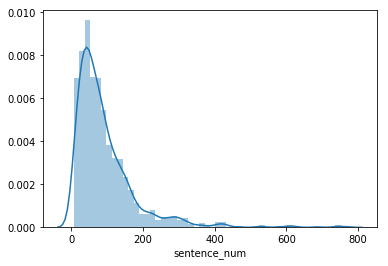

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(policy2['sentence_num'])
plt.show()

### 生成标注文件

In [203]:
id_not_in_list = []
for i in range(length):
    file_id = str(policy2.loc[i, 'policy_id'])
    print(file_id in file_id_list)
    if file_id not in file_id_list:
        id_not_in_list.append(file_id)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [391]:
length = policy2.shape[0]
for i in range(length):
    print(i)
    file_name_len = min(50, len(policy2.loc[i, 'clean_content']))
    file_id = str(policy2.loc[i, 'policy_id'])
    file_name = str(i) + '_' + policy2.loc[i, 'clean_content'][:file_name_len]+'_'+file_id
    file_name = file_name.replace('/', '')
    file_name = file_name.replace('.', '')
    origin_file = file_id_dict[file_id]
#     df = pd.DataFrame(policy2.loc[i, 'sentence_list'])
#     df.columns = ['政策原文']
    sentence_list = policy2.loc[i, 'sentence_list']

    os.mkdir('/Volumes/TOURO Mobil/policy标注/政策文件rawdata/{}'.format(str(i)))
#     df.to_excel('/Volumes/TOURO Mobil/policy标注/政策文件rawdata/{}/{}.xlsx'.format(str(i), file_name), encoding='gb18030', index=False)
    shutil.move(origin_file, '/Volumes/TOURO Mobil/policy标注/政策文件rawdata/{}'.format(str(i)))
    with open('/Volumes/TOURO Mobil/policy标注/政策文件rawdata/{}/{}.txt'.format(str(i), file_name),'w') as f:
        for j in sentence_list:
            f.write(j+'\n')
        f.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
# 对每个政策文件夹写入txt文件
length = policy2.shape[0]
for i in range(length):
# i = 0
    print(i)
    file_name_len = min(50, len(policy2.loc[i, 'clean_content']))
    file_id = str(policy2.loc[i, 'policy_id'])
    file_name = str(i) + '_' + policy2.loc[i, 'clean_content'][:file_name_len]+'_'+file_id
    file_name = file_name.replace('/', '')
    file_name = file_name.replace('.', '')
    sentence_list = policy2.loc[i, 'sentence_list']

    with open('/Volumes/TOURO Mobil/policy标注/政策文件rawdata/{}/{}.txt'.format(str(i), file_name),'w') as f:
        for j in sentence_list:
            f.write(j+'\n')
        f.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [389]:
# 从每个政策文件夹把里面的文件移动到另一个文件夹里
files = []
length = policy2.shape[0]
for i in range(length):
    file_list = glob.glob('/Volumes/TOURO Mobil/policy标注/政策文件rawdata/{}/*'.format(str(i)), recursive=True)
    files.extend(file_list)
for file in files:
    shutil.move(file, '/Volumes/TOURO Mobil/policy标注/政策原文件/')

In [24]:
# 把template.xlsx放进每个标注文件夹里
length = policy2.shape[0]
for i in range(length):
    shutil.copy('/Users/ishi/Desktop/标注/template(span).xlsx', '/Volumes/TOURO Mobil/policy标注/政策文件rawdata/{}'.format(str(i)))

In [23]:
# 从每个标注文件夹删除template.xlsx
length = policy2.shape[0]
for i in range(length):
    file_list = glob.glob('/Volumes/TOURO Mobil/policy标注/政策文件rawdata/{}/*.xlsx'.format(str(i)), recursive=True)
    for file in file_list:
        os.remove(file)

In [374]:
# 转移一些文件
for file in files:
    shutil.move(file, '/Volumes/TOURO Mobil/policy标注/政策原文件/')

### 生成一些数据表

In [26]:
policy2 = policy2.reset_index(drop=True)
policy2.insert(0, 'id', policy2.index)
policy2

,id,policy_id,file_content,clean_content,isChinese,sentence_list,sentence_num
0,0,11612309198461952,嘉开管〔2021〕13 号关于印发《2021 年度全区工业经济、科技创新、开放型经济三大类若...,嘉开管〔2021〕13号关于印发《2021年度全区工业经济、科技创新、开放型经济三大类若干政...,True,"[嘉开管〔2021〕13号, 关于印发《2021年度全区工业经济、科技创新、开放型经济三大类...",154
1,1,11612315829394432,JXJD00-2021-0007仙政发〔2021〕7号关于抓好2021年粮油生产工作的通知各...,仙政发〔2021〕7号关于抓好2021年粮油生产工作的通知各乡镇人民政府、街道办事处，县政府...,True,"[仙政发〔2021〕7号, 关于抓好2021年粮油生产工作的通知各乡镇人民政府、街道办事处，...",72
2,2,11612315899386880,FJSD00-2021-0001嘉善县人民政府文件善政发〔2021〕6号嘉善县人民政府关于鼓...,嘉善县人民政府文件善政发〔2021〕6号嘉善县人民政府关于鼓励企业利用多层次资本市场促进经济...,True,"[善政发〔2021〕6号, 嘉善县人民政府关于鼓励企业利用多层次资本市场促进经济高质量发展的...",135
3,3,11612318084357120,ZJFC01-2021-0005嘉政办发〔2021〕16号嘉兴市人民政府办公室关于继续实施惠...,嘉政办发〔2021〕16号嘉兴市人民政府办公室关于继续实施惠企政策促进经济稳中求进的若干意见...,True,"[嘉政办发〔2021〕16号, 嘉兴市人民政府办公室关于继续实施惠企政策促进经济稳中求进的若...",86
4,4,11612318159854592,ZJFC01-2021-0004嘉政办发〔2021〕15号嘉兴市人民政府办公室关于加快生物医...,嘉政办发〔2021〕15号嘉兴市人民政府办公室关于加快生物医药产业高质量发展的若干意见各县（...,True,"[嘉政办发〔2021〕15号, 嘉兴市人民政府办公室关于加快生物医药产业高质量发展的若干意见...",81
...,...,...,...,...,...,...,...
1320,1320,11612866294832128,椒政办发〔2011〕139 号关于印发台州市椒江区产业扶持专项引导资金管理办法的通知各街道办...,椒政办发〔2011〕139号关于印发台州市椒江区产业扶持专项引导资金管理办法的通知各街道办事...,True,"[椒政办发〔2011〕139号, 关于印发台州市椒江区产业扶持专项引导资金管理办法的通知, ...",45
1321,1321,11612866821217280,国务院关于印发进一步鼓励软件产业和集成电路产业发展若干政策的通知国发〔2011〕4号各省、自...,国务院关于印发进一步鼓励软件产业和集成电路产业发展若干政策的通知国发〔2011〕4号各省、自...,True,"[国务院关于印发进一步鼓励软件产业和集成电路产业发展若干政策的通知国发〔2011〕4号, 各...",91
1322,1322,11612867604503552,交通运输部、国家发展改革委《关于进一步完善和落实鲜活农产品运输绿色通道政策的通知》交公路发【...,交通运输部、国家发展改革委《关于进一步完善和落实鲜活农产品运输绿色通道政策的通知》交公路发【...,True,[交通运输部、国家发展改革委《关于进一步完善和落实鲜活农产品运输绿色通道政策的通知》交公路发...,38
1323,1323,11612868403780608,兰银〔2008〕7 号 市农村信用合作联社、农信担保有限公司： 为进一步推动我市来料加工业...,兰银〔2008〕7号市农村信用合作联社、农信担保有限公司：为进一步推动我市来料加工业务，培育...,True,"[兰银〔2008〕7号, 市农村信用合作联社、农信担保有限公司：, 为进一步推动我市来料加工...",93


In [38]:
policy_json = policy2.drop(columns=['isChinese']).to_json(orient="index",force_ascii=False)
with open('./data/policy_data.json', 'w') as f:
    json.dump(policy_json, f)
    f.close()

In [30]:
policy_id = policy2[['id', 'policy_id', 'sentence_num']].to_json(orient="index",force_ascii=False)
with open('./data/policy_id.json', 'w') as f:
    json.dump(policy_id, f)
    f.close()

In [5]:
people = pd.DataFrame([['王昕', '20307090013'], ['虎雪', '19307090201'], ['苏慧怡', '19307090197'], ['赵子昂', '20307090056'], ['王心恬', '19307090134'],
                      ['冷方琼', '20307090139'], ['周人芨', '19307090009'], ['南楠', '20307090155'], ['姜静宜', '19307090065'], ['陈奔逸', '19307090045'],
                      ['苏品菁', '20307090170'], ['李俊昊', '21210980011'], ['王远', '20307090213'], ['张宇恬', '19307090122'], ['初子菡', '18307090138'], 
                      ['陈涛', '19307090052'], ['严可欣', '19307090078'], ['徐雪', '21210170019'], ['柏柯羽', '20307090147'], ['帕提曼', '19307090210'], ['贺凡熙', '21210170020']])
people.columns = ['name', 'student_id']

In [6]:
people

,name,student_id
0,王昕,20307090013
1,虎雪,19307090201
2,苏慧怡,19307090197
3,赵子昂,20307090056
4,王心恬,19307090134
5,冷方琼,20307090139
6,周人芨,19307090009
7,南楠,20307090155
8,姜静宜,19307090065
9,陈奔逸,19307090045


In [7]:
people_json = people.to_json(orient="index",force_ascii=False)
with open('./data/people_id.json', 'w') as f:
    json.dump(people_json, f)
    f.close()

### 读取标注数据

In [10]:
folder_list = glob.glob('/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/*', recursive=True)
file_list = []
for folder in folder_list:
    file_list.extend(glob.glob(folder + '/*-*.xlsx'))

In [11]:
file_list

['/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/141-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/151-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/145-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/155-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/146-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/156-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/142-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/152-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/147-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/157-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/143-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/153-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/144-南楠.xlsx',
 '/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/154-南楠.xlsx',
 '/Vol

In [12]:
clean_file = pd.DataFrame(columns=['id', 'name', 'sentence_num'])
for file in file_list:
    new_id, name = file.split('.')[0].split('/')[-1].split('-')
    content = pd.read_excel(file).dropna(how='all')
    sentence_num = content.shape[0]
    clean_file = clean_file.append({'id':new_id, 'name':name, 'sentence_num':sentence_num}, ignore_index=True)

In [13]:
sentence_sta = pd.DataFrame(clean_file.groupby('name')['sentence_num'].sum()).reset_index()
sentence_sta = pd.merge(sentence_sta, people)
sentence_sta['salary'] = sentence_sta['sentence_num'] / 10

In [14]:
sentence_sta

,name,sentence_num,student_id,salary
0,严可欣,1153,19307090078,115.3
1,冷方琼,1397,20307090139,139.7
2,初子菡,1926,18307090138,192.6
3,南楠,1814,20307090155,181.4
4,周人芨,563,19307090009,56.3
5,姜静宜,1177,19307090065,117.7
6,帕提曼,559,19307090210,55.9
7,张宇恬,609,19307090122,60.9
8,徐雪,2096,21210170019,209.6
9,李俊昊,93,21210980011,9.3


In [17]:
sentence_sta.to_csv('./data/salary_1stmonth.csv', encoding="utf_8_sig")

## 2 统计变量

In [110]:
folder_list = glob.glob('/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/*', recursive=True)
file_list = []
for folder in folder_list:
    file_list.extend(glob.glob(folder + '/*-*.xlsx'))

entry_cols = ["变量"+str(i) for i in range(1, 16)]
field_cols = ["域"+str(i) for i in range(1, 16)]

In [111]:
var_dict = defaultdict(int)
for file in file_list:
    new_id, name = file.split('.')[0].split('/')[-1].split('-')
    content = pd.read_excel(file).dropna(how='all')
    for col in entry_cols:
        entry_var = content.loc[:, col].dropna()
        for var in entry_var:
            var_dict[var] += 1
var_dict = sorted(var_dict.items(), key=lambda d: -d[1])

In [112]:
len(var_dict)

1194

In [113]:
var_dict

[('企业', 1634),
 ('企业荣誉', 652),
 ('企业标准', 516),
 ('企业类型', 156),
 ('业务领域', 140),
 ('项目荣誉', 84),
 ('企业业务领域', 77),
 ('奖励对象', 72),
 ('项目标准', 63),
 ('注册地', 59),
 ('项目', 58),
 ('项目类型', 56),
 ('等级', 54),
 ('机构', 35),
 ('桐乡市教育型企业', 30),
 ('补助对象', 29),
 ('企业风险', 28),
 ('企业经营', 24),
 ('企业年主营业务收入首次', 24),
 ('技术改造项目实际投资额', 23),
 ('荣誉获得时间', 22),
 ('投资总额', 21),
 ('时间', 19),
 ('企业注册地', 19),
 ('次数', 18),
 ('企业项目', 17),
 ('公司类型', 17),
 ('事务所', 17),
 ('业务', 16),
 ('扶持对象', 16),
 ('固定资产投资', 16),
 ('类别', 16),
 ('员工', 15),
 ('创业人员', 15),
 ('当年实缴税金', 15),
 ('企业主营业务收入', 14),
 ('企业产品', 13),
 ('贡献金额', 13),
 ('企业当年营业收入', 13),
 ('园区类型', 12),
 ('企业年计税销售净增', 12),
 ('企业年计税销售增幅', 12),
 ('工作室荣誉', 12),
 ('营业收入', 12),
 ('当年纳税销售', 12),
 ('年营业收入', 11),
 ('企业年销售收入首次', 11),
 ('支持对象', 11),
 ('人才类型', 11),
 ('进口品', 11),
 ('评选类别', 11),
 ('园区荣誉', 11),
 ('企业员工', 11),
 ('主体', 10),
 ('人员', 10),
 ('园区', 10),
 ('单位标准', 10),
 ('民宿荣誉', 10),
 ('实际（设备和软件）投入', 10),
 ('亩产税收比同行业亩均税收增加', 10),
 ('上年度营业收入', 9),
 ('销售额', 9),
 ('企业年直播销售额', 9),
 (

In [98]:
var_field_dict = defaultdict(defaultdict)
for file in file_list:
    print(file)
    new_id, name = file.split('.')[0].split('/')[-1].split('-')
    content = pd.read_excel(file).dropna(how='all')
    for i in range(0, 15):
        entry = content.loc[:, [entry_cols[i], field_cols[i]]].dropna().values
        for var in entry:
            if var[1] in var_field_dict[var[0]]:
                var_field_dict[var[0]][var[1]] += 1
            else:
                var_field_dict[var[0]][var[1]] = 1
for var_field in var_field_dict:
    var_field_dict[var_field] = sorted(var_field_dict[var_field].items(), key=lambda d: -d[1])

/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/141-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/151-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/145-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/155-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/146-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/156-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/142-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/152-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/147-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/157-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/143-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/153-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/144-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/154-南楠.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/南楠-第一周/148-南楠.

/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/王昕-第一周/28-王昕.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/王昕-第一周/20-王昕.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/王远-第一周/241-王远.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/王远-第一周/258-王远.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/王远-第一周/259-王远.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/王远-第一周/240-王远.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/王远-第一周/257-王远.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/王远-第一周/255-王远.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/徐雪-第一周/325-徐雪.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/徐雪-第一周/335-徐雪.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/徐雪-第一周/334-徐雪.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/徐雪-第一周/324-徐雪.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/徐雪-第一周/326-徐雪.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/徐雪-第一周/336-徐雪.xlsx
/Volumes/TOURO Mobil/policy标注/政策文件annotated/第一周/徐雪-第一周/337-徐雪.xl

In [116]:
clean_var_field_dict = {}
for var, freq in var_dict:
    clean_var_field_dict[var] = (freq, var_field_dict[var])

In [115]:
clean_var_field_dict

{'企业': (1634,
  [('小微企业', 25),
   ('工业企业', 23),
   ('中小企业', 17),
   ('注册当年实现单位统计入库', 12),
   ('月度进入规上企业统计', 12),
   ('租赁办公用房', 11),
   ('参保企业', 10),
   ('中小微企业', 9),
   ('新引进', 9),
   ('实现正增长', 9),
   ('增速高于全市平均增速', 9),
   ('受疫情影响的企业', 8),
   ('生产型企业', 7),
   ('购买自用商业办公用房', 7),
   ('受疫情影响较大的企业', 6),
   ('金融机构', 6),
   ('物流企业', 6),
   ('独立法人资格', 6),
   ('制造业企业', 6),
   ('工业互联网平台', 6),
   ('一等奖', 6),
   ('亩均效益省级“领跑者”企业', 6),
   ('较上一年增长', 6),
   ('线上批零住餐企业', 6),
   ('二等奖', 6),
   ('其他营利性服务业企业经营者', 6),
   ('三等奖', 6),
   ('规上企业', 5),
   ('不裁员企业', 5),
   ('少裁员企业', 5),
   ('具有独立法人资格', 5),
   ('与券商、会计师事务所、律师事务所签订服务协议', 5),
   ('经认定的', 4),
   ('安全生产标准化企业', 4),
   ('疫情防控重点保障物资生产企业', 3),
   ('个体工商户', 3),
   ('电子商务企业', 3),
   ('MCN机构', 3),
   ('软件和信息服务企业', 3),
   ('上市公司', 3),
   ('科技型企业', 3),
   ('面临暂时性生产经营困难', 3),
   ('恢复有望', 3),
   ('人才创业企业', 3),
   ('上报省证监局上市辅导', 3),
   ('向中国证监会递交首发上市申请材料', 3),
   ('获发审委核准通过', 3),
   ('入驻科技孵化器', 3),
   ('自购办公用房', 3),
   ('股权投资企业', 3),
   ('总部型培育企业', 3),
   ('符

In [117]:
with open('./data/var_field_count.json', 'w') as f:
    json.dump(clean_var_field_dict, f)

In [124]:
for d in clean_var_field_dict:
    print(d)
    print(clean_var_field_dict[d])
    print("=============================")

企业
(1634, [('小微企业', 25), ('工业企业', 23), ('中小企业', 17), ('注册当年实现单位统计入库', 12), ('月度进入规上企业统计', 12), ('租赁办公用房', 11), ('参保企业', 10), ('中小微企业', 9), ('新引进', 9), ('实现正增长', 9), ('增速高于全市平均增速', 9), ('受疫情影响的企业', 8), ('生产型企业', 7), ('购买自用商业办公用房', 7), ('受疫情影响较大的企业', 6), ('金融机构', 6), ('物流企业', 6), ('独立法人资格', 6), ('制造业企业', 6), ('工业互联网平台', 6), ('一等奖', 6), ('亩均效益省级“领跑者”企业', 6), ('较上一年增长', 6), ('线上批零住餐企业', 6), ('二等奖', 6), ('其他营利性服务业企业经营者', 6), ('三等奖', 6), ('规上企业', 5), ('不裁员企业', 5), ('少裁员企业', 5), ('具有独立法人资格', 5), ('与券商、会计师事务所、律师事务所签订服务协议', 5), ('经认定的', 4), ('安全生产标准化企业', 4), ('疫情防控重点保障物资生产企业', 3), ('个体工商户', 3), ('电子商务企业', 3), ('MCN机构', 3), ('软件和信息服务企业', 3), ('上市公司', 3), ('科技型企业', 3), ('面临暂时性生产经营困难', 3), ('恢复有望', 3), ('人才创业企业', 3), ('上报省证监局上市辅导', 3), ('向中国证监会递交首发上市申请材料', 3), ('获发审委核准通过', 3), ('入驻科技孵化器', 3), ('自购办公用房', 3), ('股权投资企业', 3), ('总部型培育企业', 3), ('符合浙江省产业导向', 3), ('两年连续被评为“工业企业30强”', 3), ('实现境内上市', 3), ('完成股改', 3), ('当年进入浙江股权交易中心成长板挂牌', 3), ('当年列入国家级制造业单项冠军示范企业名单', 3), ('当年列入省级隐形冠军名单', 3), ('当年列入绍兴市级隐形冠军'

(1, [('100万元', 1)])
申报年度平台网络销售额同比增幅
(1, [(0.2, 1)])
社交电商企业
(1, [('新引进', 1)])
直播电商平台企业
(1, [('新引进', 1)])
传统生产型企业
(1, [('开展电子商务活动', 1)])
管理机构
(1, [('新引进的知名管理机构', 1)])
企业作用
(1, [('有效促进嘉兴市智慧旅游发展', 1)])
组织机构
(1, [('市文化广电旅游局', 1)])
企业开发建设
(1, [('基于新技术的综合管理系统', 1)])
补助线路
(1, [('夜游班线', 1)])
企业数据平台
(1, [('与市旅游大数据平台实现数据对接', 1)])
补助路线
(1, [('旅行社组织的散客班线', 1)])
集装箱吞吐量
(1, [('较上年增长', 1)])
是否购买专利保险
(1, [('购买专利保险', 1)])
知识产权维护
(1, [('在国外提起专利侵权诉讼最终判定专利侵权成立', 1)])
企业运作
(1, [('通过专利合作条约（PCT）向国外申请专利', 1)])
企业纳税年增长幅度
(1, [(0.1, 1)])
重大项目开工时间
(1, [('2个月', 1)])
引入主体
(1, [('天使投资机构', 1)])
团队
(1, [('大学生创新创业团队', 1)])
范围
(1, [('湖州市', 1)])
引进主体
(1, [('中介机构', 1)])
符合要求
(1, [('我市主导产业', 1)])
引进的机构总部
(1, [('在湖设立的年税收超2000万元的（机构）总部的', 1)])
固定资产投资周期
(1, [('首期', 1)])
上规时间
(1, [('24个月', 1)])
经营地点
(1, [('湖州市', 1)])
引入方式
(1, [('由外地引入至本市', 1)])
落户地
(1, [('湖州市', 1)])
服务企业
(1, [('100家', 1)])
生产时间
(1, [('当年', 1)])
经营金额
(1, [('200万', 1)])
排名类型
(1, [('全球综合排名', 1)])
项目状态
(1, [('已运行', 1)])
产业项目
(1, [('房地产', 1)])
亩平均税收
(1, [('30万', 1)